Получаем данные о результатах ЕГЭ с mos.ru

In [1]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://apidata.mos.ru/v1/datasets/2072/rows' 

parameters = {
    'api_key': '1b205986adb3e7e7dd5161a765d55ee9',
    'top': 1,
}
headers = {
  'Content-Type': 'application/json',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  results_raw = json.loads(response.text)
  #print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)


Получаем данные о локациях школ с mos.ru

In [2]:
url = 'https://apidata.mos.ru/v1/datasets/2263/features'

try:
  response = session.get(url, params=parameters)
  schools_raw = json.loads(response.text)
  #print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)


Переводим данные о школах и результатах ЕГЭ dataframe

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)

schools_raw_df = pd.json_normalize(schools_raw['features'])
results_raw_df = pd.json_normalize(results_raw)

Поулучаем данные о кол-ве учашихся в школах из архива data.mos.ru актуальные на май 2021, они совпадают с периодом сдачи ЕГЭ. 

In [4]:
import re

students_raw_df = pd.read_csv('schools_rating/schools-2021-05-31.csv')
students = pd.DataFrame(students_raw_df['FullName'])
for index, row in students_raw_df.iterrows():
    if type(students_raw_df.loc[index,'NumberofStudentsInOO']) != float:
        students.loc[index, 'students'] = float(re.findall('[0-9]+',  row['NumberofStudentsInOO'])[0])

Извлекаем данные о локации школ и кол-ве студентов

In [5]:
schools = pd.DataFrame(schools_raw_df['properties.Attributes.FullName'])
schools.rename(columns = {'properties.Attributes.FullName':'fullName'}, inplace = True)

In [6]:
for index, row in schools_raw_df.iterrows():
    if row['geometry.type'] == 'MultiPolygon':
        schools.loc[index, 'long'] = row['geometry.coordinates'][0][0][0][0]
        schools.loc[index, 'lat'] = row['geometry.coordinates'][0][0][0][1]
    if row['geometry.type'] == 'Polygon':
        schools.loc[index, 'long'] = row['geometry.coordinates'][0][0][0]
        schools.loc[index, 'lat'] = row['geometry.coordinates'][0][0][1]
    tmp = students.loc[students.FullName == row['properties.Attributes.FullName'], 'students']
    if len(tmp) > 0:
        schools.loc[index, 'students'] = tmp.item()

Объеденяем данные о школах с результатами ЕГЭ

In [7]:
results_raw_df.rename(columns = {'Cells.EDU_NAME':'fullName', 'Cells.YEAR':'year', 'Cells.District': 'district', 'Cells.PASSES_OVER_220':'over_220', 'Cells.PASSER_UNDER_160': 'over_160'}, inplace = True)

In [8]:
results_raw_df = results_raw_df[results_raw_df['year'] == "2020-2021"]
results = results_raw_df.merge(schools,how='left',on='fullName')

Добавляем пропущенные значения, которые можно найти в открытом доступе

In [9]:
row_indexer = results[results["lat"].isnull() & results["students"]].index[0] 
results.loc[row_indexer,'long'] = 37.493497
results.loc[row_indexer,'lat'] = 55.567535

Добавляем рейтинги школ(smart_rate_160 и smart_rate_220). Формула расчета: кол-во сдавших деленное на общее кол-во учашихся в школах. т.к информацию о кол-ве сдававших ЕГЭ по школам в открытом доступе нет

In [10]:
for index, row in results.iterrows():
    results.loc[index,'district'] = row['district'].replace('район ', '').replace(' район', '')
    if row['students']:
        results.loc[index,'smart_rate_160'] = row['over_160']/row['students']
        results.loc[index,'smart_rate_220'] = row['over_220']/row['students']

Удаляем строки, для которых не удалось найти недостающую информацию

In [11]:
ind_missing = results[results['long'].isnull() | results['students'].isnull()].index
results_cleaned = results.drop(ind_missing, axis=0)

In [12]:
districts = pd.DataFrame(results_cleaned.groupby('district', as_index=False)[['smart_rate_160', 'smart_rate_220']].mean())
districts

,district,smart_rate_160,smart_rate_220
0,Академический,0.053528,0.029655
1,Алексеевский,0.044678,0.022164
2,Алтуфьевский,0.035936,0.018151
3,Арбат,0.051368,0.029375
4,Аэропорт,0.057800,0.033795
...,...,...,...
130,поселение Краснопахорское,0.017013,0.005293
131,поселение Московский,0.025526,0.010161
132,поселение Рязановское,0.028911,0.014119
133,поселение Сосенское,0.025701,0.011545


In [13]:
import geopandas as gpd
%matplotlib inline
mo_gdf = gpd.read_file('schools_rating/atd/mo.shp')
mo_gdf

ImportError: the 'read_file' function requires the 'fiona' package, but it is not installed or does not import correctly.
Importing fiona resulted in: DLL load failed while importing ogrext: Не найден указанный модуль.

<AxesSubplot:>

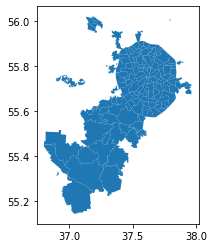

In [208]:
mo_gdf.plot()

In [ ]:
mo_gdf_wm = mo_gdf.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
mo_gdf_wm.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

In [ ]:
districts['district'] = districts['district'].str.lower()
districts['district'] = districts['district'].str.replace('ё', 'е')
mo_gdf_wm['name_low'] = mo_gdf_wm['NAME'].str.lower()
mo_gdf_wm['name_low'] = mo_gdf_wm['name_low'].str.replace('ё', 'е')
full_gdf = districts.merge(mo_gdf_wm[['geometry', 'name_low']], left_on='district', right_on='name_low', how='left')
full_gdf = gpd.GeoDataFrame(full_gdf)

In [ ]:
full_gdf[full_gdf['name_low'].isnull()] 

In [ ]:
rating_plot = full_gdf.plot(column = 'smart_rate_220', linewidth=0, cmap='BuPu', legend=True, figsize=[15,15])

In [ ]:
import folium
import matplotlib
import mapclassify
full_gdf.explore()